# Solution


In [59]:
import numpy as np
from collections import defaultdict


ACTIONS = {0: [0,0], 1: [1,0], 2: [0, 1], 3:[-1, 0], 4:[0, -1]}

def process_input(matrix):

  desiarable_area =[]
  h,w = len(matrix), len(matrix[0])
  cargo_count = 0
  cargo_pos = defaultdict(list)

  
  for i in range(h):
    for j in range(w):

        if matrix[i][j] == 'r':
          desiarable_area.append([i,j])
          matrix[i][j] = 0
        else:
          matrix[i][j] = int(matrix[i][j])
          if matrix[i][j] != 0:
            cargo_pos[ matrix[i][j]].append([i, j])
          
        
        cargo_count = max(cargo_count, matrix[i][j])

  matrix = np.array(matrix)
   
    # adding new axis to account for overlaps
  matrix = matrix[:, :,  np.newaxis] 


  return  h, w, desiarable_area, cargo_count,cargo_pos













class GridWorld():

  def __init__(self, matrix):



    self.h, self.w, self.desiarable_area, self.cargo_count, self.initial_cargo_pos = process_input(matrix)
  
    self.action_space = [[i for i in range(5)]] * self.cargo_count
    self.action_space = np.array(self.action_space)

    self.state_cargo_pos = self.initial_cargo_pos.copy()

   
    self.reward = 0
    self.done = False


  def get_state(self, cargo):
    """
  returns a [3,w,h] tensor of representation
  of the current state. 
    """
    inp = np.zeros(shape=(3, self.h, self.w), dtype=np.float32)
    # dim 1 => for des_area 2-> wanted cargo 3-> other cargos 

    for coord in self.desiarable_area:
      inp[0][coord[0]][coord[1]] = 1

    
    
    for coord in self.state_cargo_pos[cargo]:
      inp[1][coord[0]][coord[1]] = 1

    for c in self.state_cargo_pos:
      if c == cargo:
        continue
      for coord in self.state_cargo_pos[c]:
        inp[2][coord[0]][coord[1]] = 1
     
    
    return torch.from_numpy(inp)






  def render(self):

    # print our state
     print(self.state_cargo_pos)

     print(f"rewards are {self.reward}")

  
  def reset(self):
    # reset the obsv space to the initial matrix
    self.state_cargo_pos = self.initial_cargo_pos.copy()
    self.reward = 0 
    self.done = False


  def check(self,x, y):
    return x >=  0 and y >= 0 and x < self.h and y < self.w 



  def is_done(self):
    
    for cargo in range(1, self.cargo_count + 1):

        # return false if one is not in desiarable area
        for coord in self.state_cargo_pos[cargo]:
          if coord not in self.desiarable_area:
            return False

      # return false of one is overlapping 
        for other_cargos in range(cargo + 1 , self.cargo_count + 1):
          for coord in self.state_cargo_pos[cargo]:
            if coord in self.state_cargo_pos[other_cargos]:
              return False
      
    return True
    


  def get_nxt_state(self, action_idx, cargo_wanted):

    x , y = ACTIONS[action_idx][0] , ACTIONS[action_idx][1] 


    moved = True
    lst = []

    for coord in self.state_cargo_pos[cargo_wanted]:
      if self.check(coord[0] + x , coord[1] + y):
        lst.append([coord[0] + x, coord[1] + y])
      else :
        #
        moved = False
        break
      
    if moved:
        self.state_cargo_pos[cargo_wanted] = lst

    self.done = self.is_done()


    return moved, self.done




    
  
  def calc_reward(self):
    r = 0


    for cargo in range(1, self.cargo_count + 1):

      # add 1 if any cell is in desiarable area
      for coord in self.state_cargo_pos[cargo]:
        if coord in self.desiarable_area:
          r += 1
          # print("in desiarable area + 1")
          # print(f"current r is {r}")

     # subtract 1 if there is any overlap
      for other_cargos in range(cargo + 1 , self.cargo_count + 1):
        for coord in self.state_cargo_pos[cargo]:
          if coord in self.state_cargo_pos[other_cargos]:
            
            r -= 1


      
    self.reward = r


  def step(self, action_idx, cargo_wanted):

    # get next state
    moved,_ = self.get_nxt_state(action_idx, cargo_wanted)


    # calculate reward
    if moved :
       self.calc_reward()
    else :
      # it means cargo hit a wall
      self.reward = -1
    return self.reward, self.done 


       
      





mat = [["0", "0", "2", "2", "0"],
       ["0", "r", "r", "r", "0"],
       ["0", "r", "r", "r", "1"],
       ["0", "r", "r", "r", "1"],
       ["0", "0", "0", "0", "1"],
]

env = GridWorld(mat)

In [38]:
from collections import namedtuple, deque
import random 

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [46]:
# Network architecture
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(nn.Module):
    def __init__(self, n_actions):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, n_actions, kernel_size=3, stride=1)
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.adaptive_avg_pool2d(x, output_size=1)
        return x.view(x.size(0), -1) # will return batch size x 1 the action choosen for that state

In [53]:
import matplotlib
import matplotlib.pyplot as plt
# Initialize some variables

#env = GridWorld(mat)
episode_durations = []

# Hyperparameters 
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 800
TARGET_UPDATE = 10
n_actions = 5

steps_done = 0

# Models
policy_net = Model(5).to(device)
target_net = Model(5).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(500)





In [54]:
import math
# helper functions

def select_action(state):
    global steps_done
   # print(state.shape)
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action = policy_net(state).max(1)[1].view(1, 1)
            return action
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)



def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [55]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
      
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.tensor(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net

    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1).to(device))

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

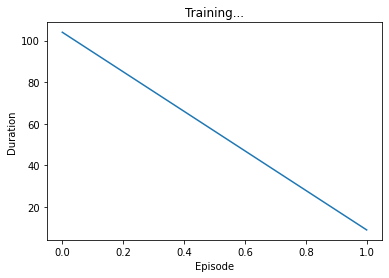

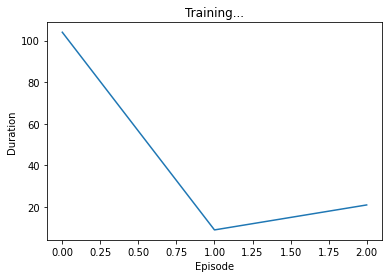

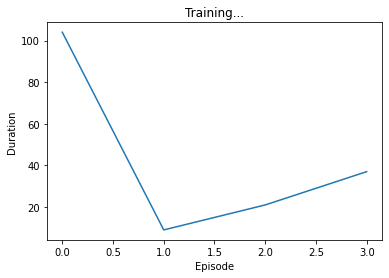

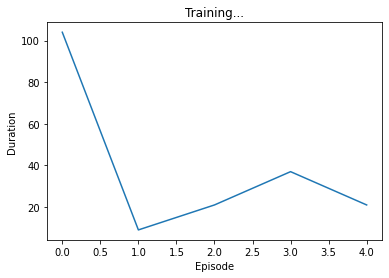

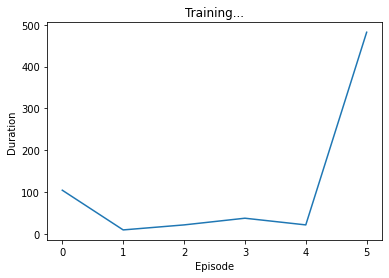

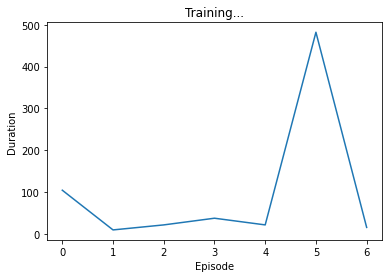

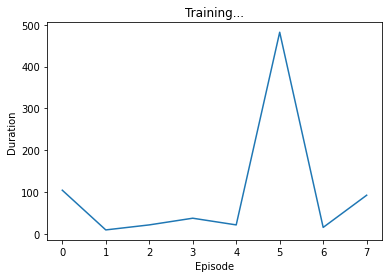

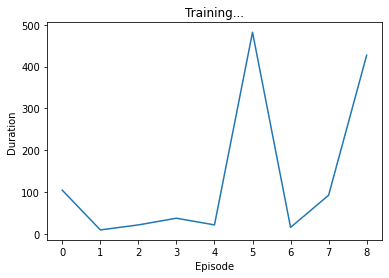

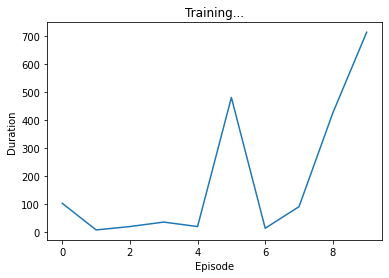

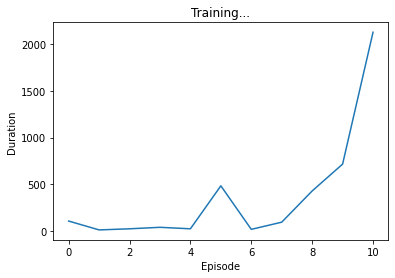

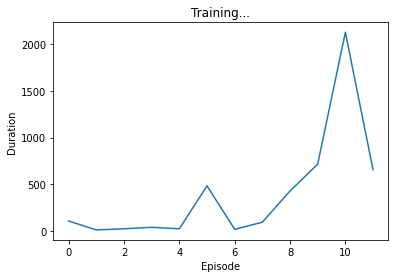

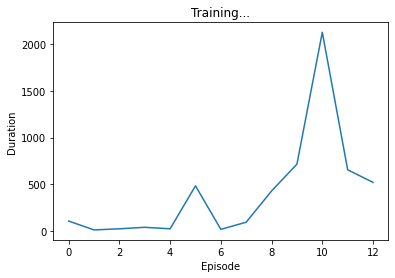

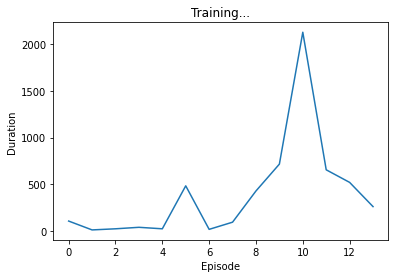

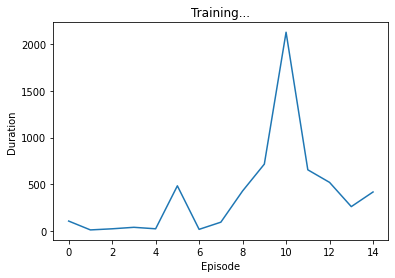

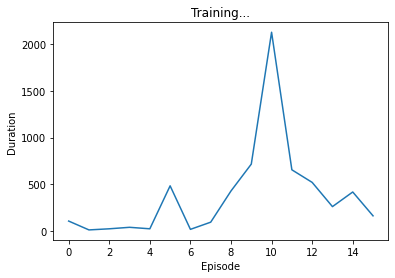

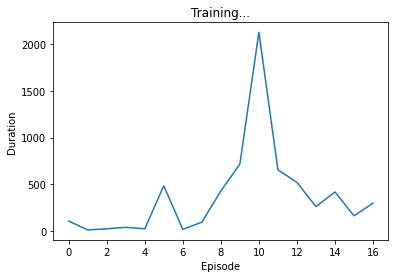

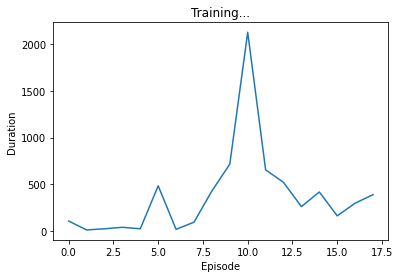

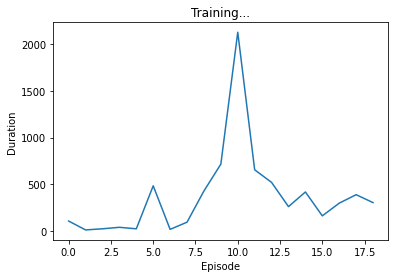

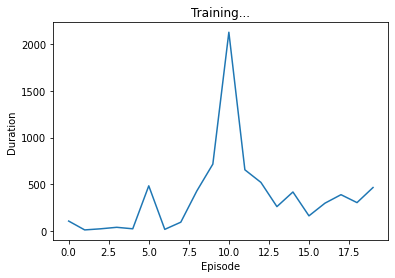

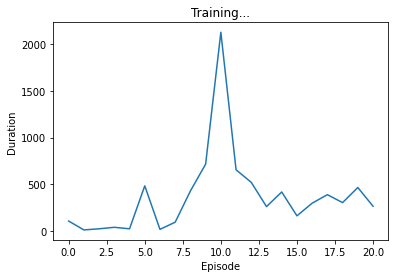

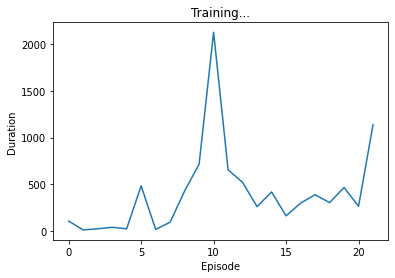

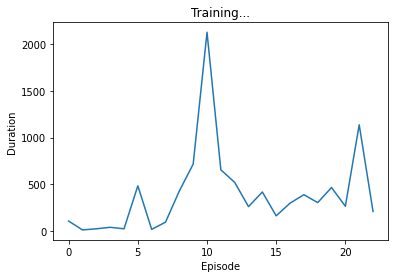

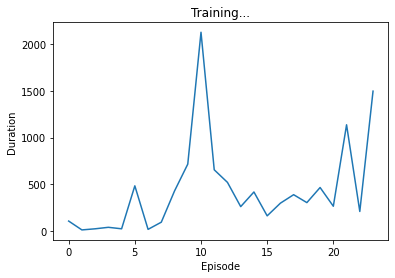

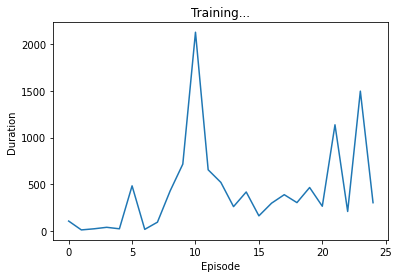

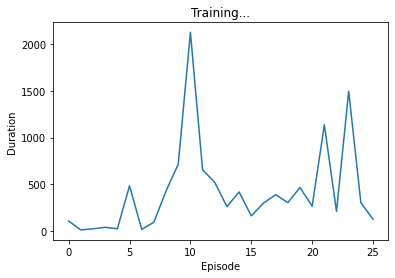

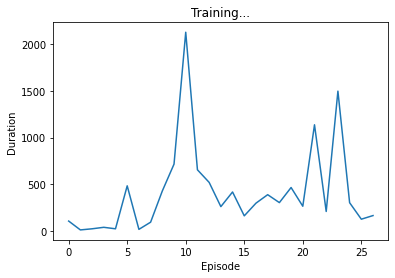

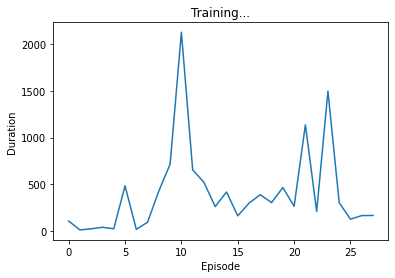

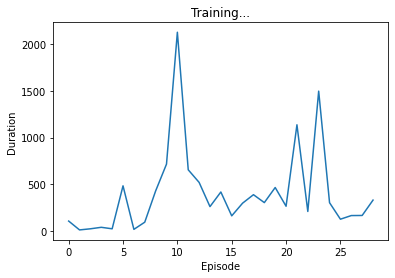

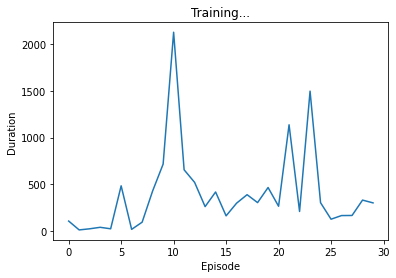

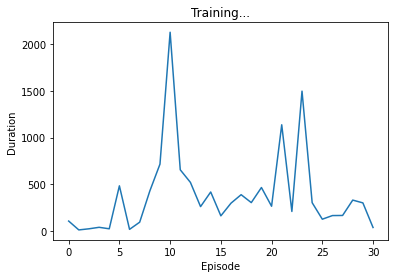

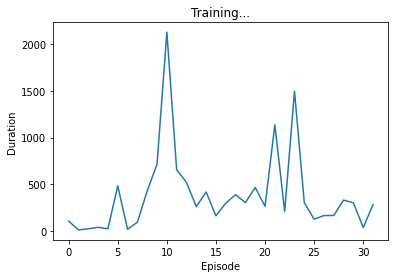

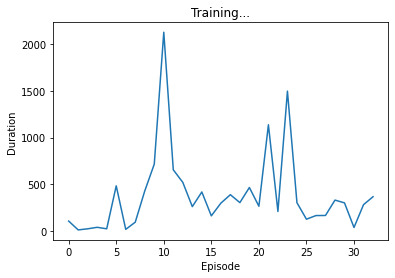

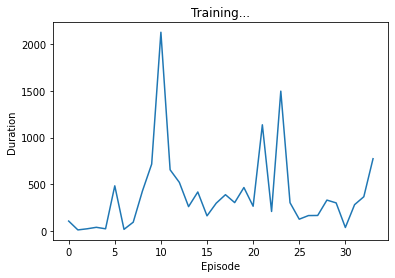

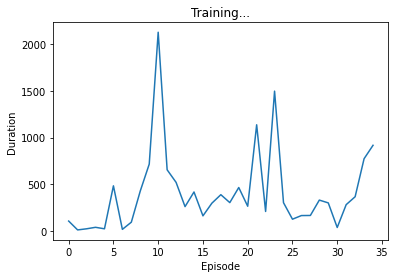

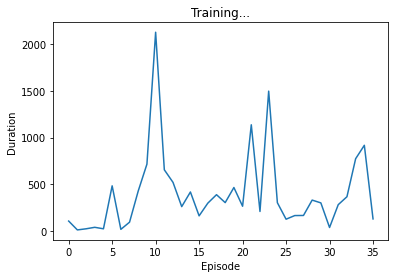

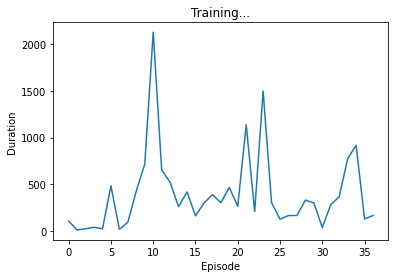

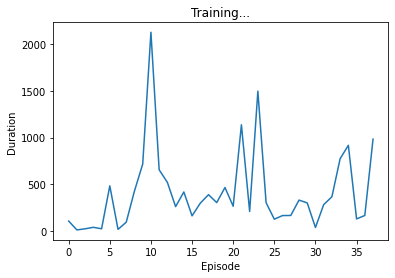

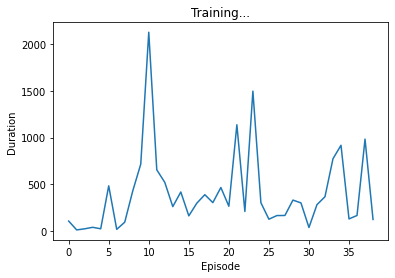

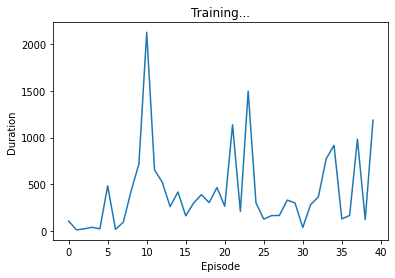

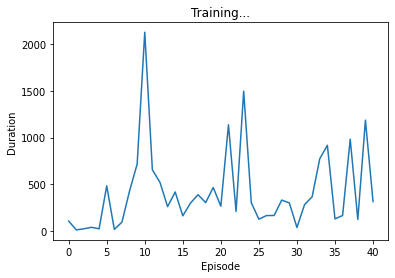

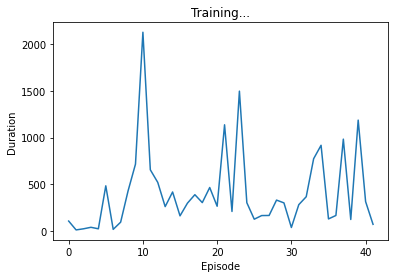

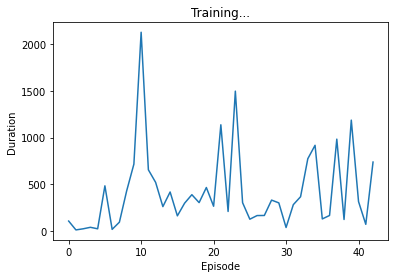

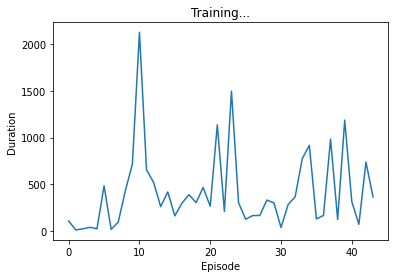

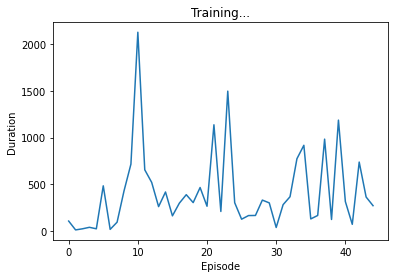

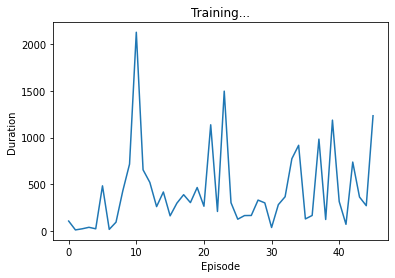

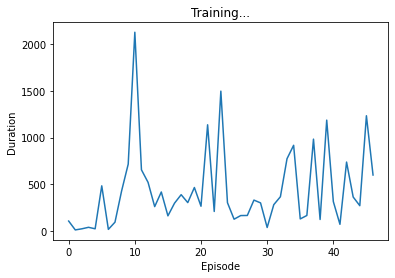

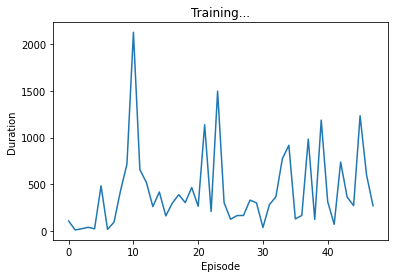

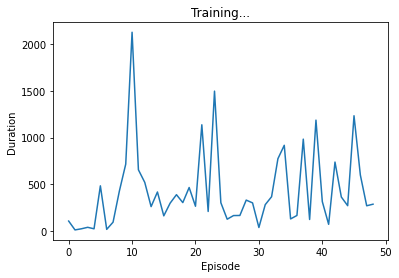

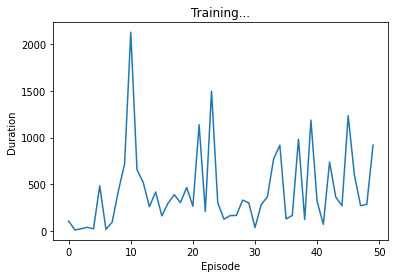

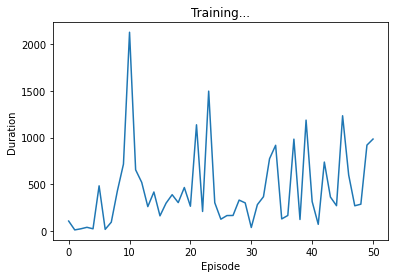

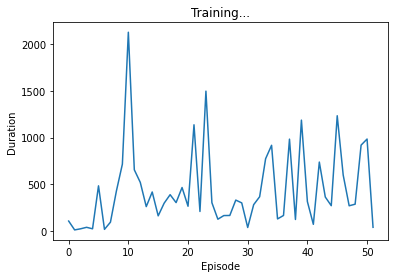

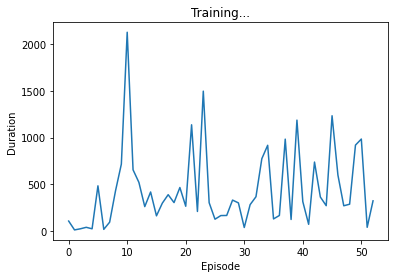

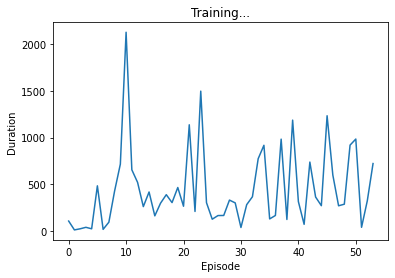

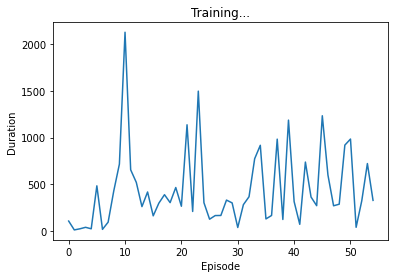

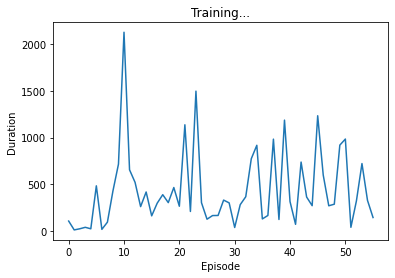

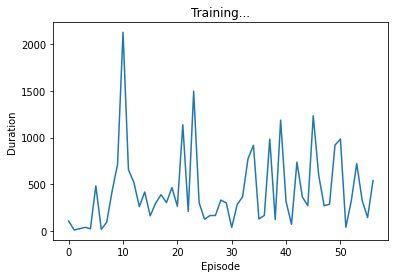

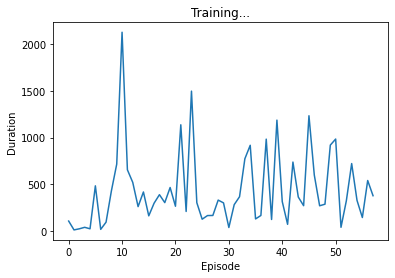

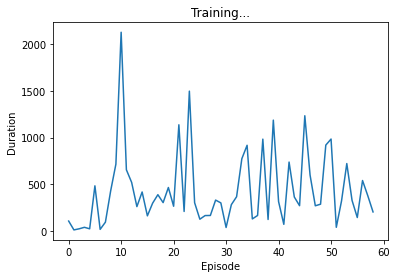

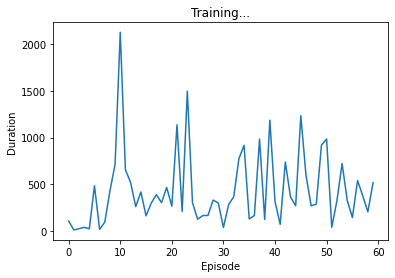

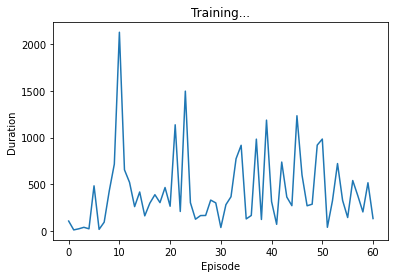

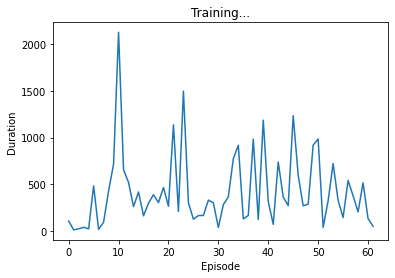

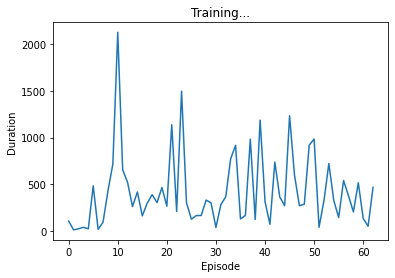

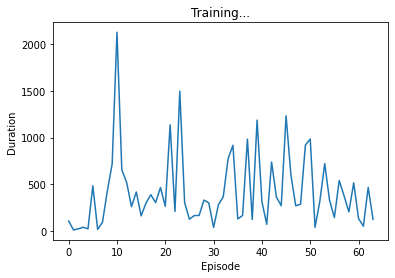

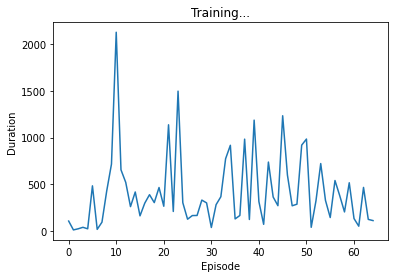

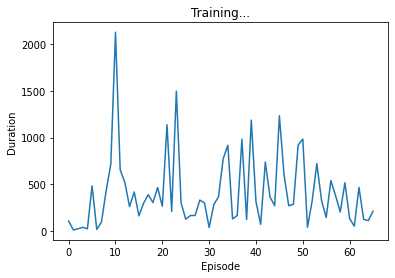

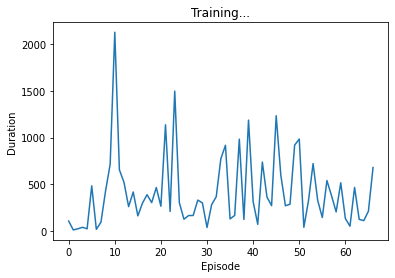

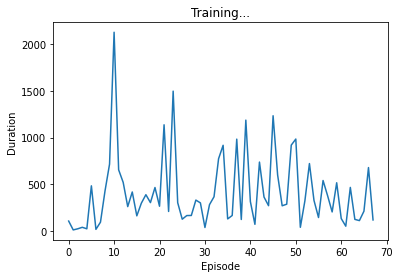

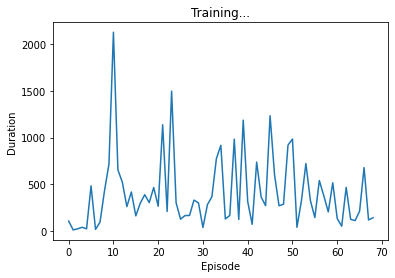

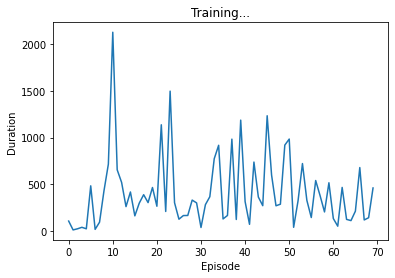

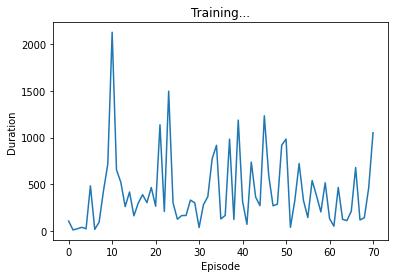

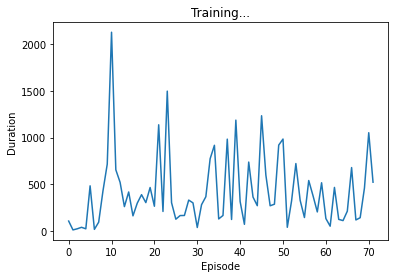

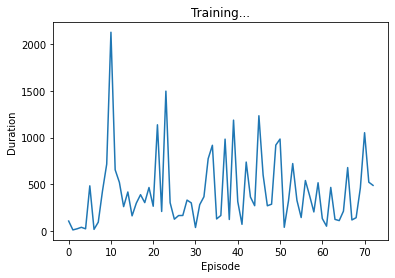

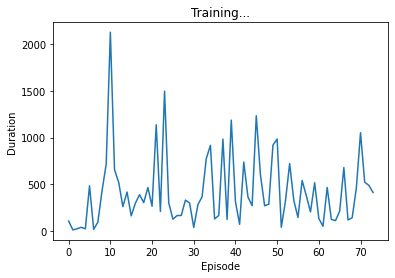

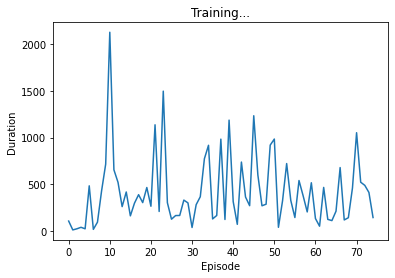

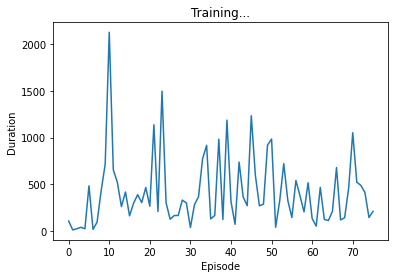

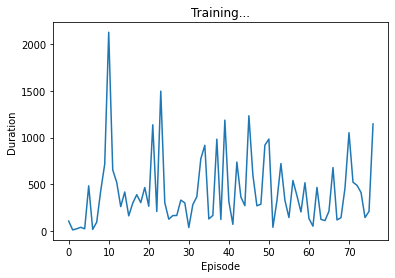

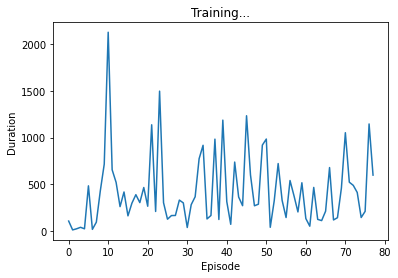

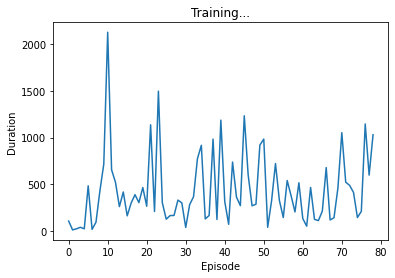

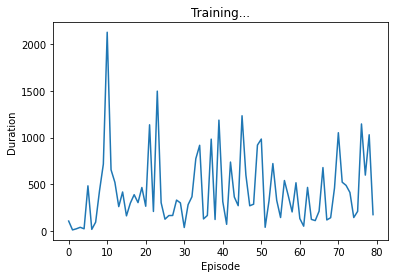

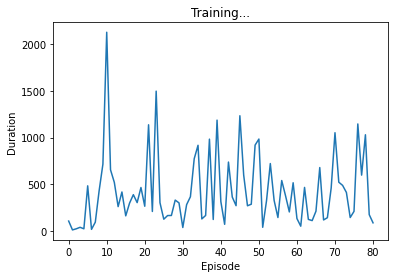

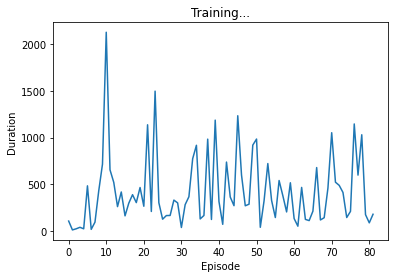

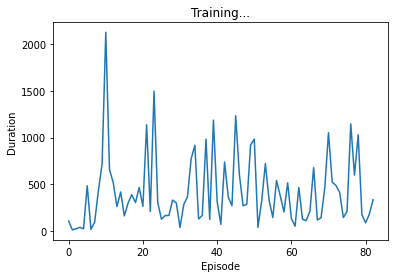

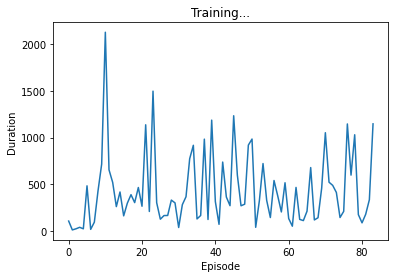

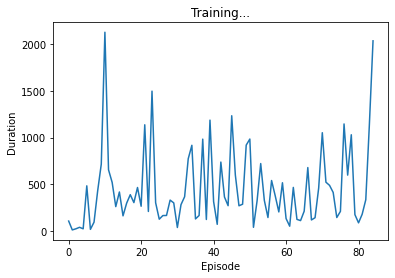

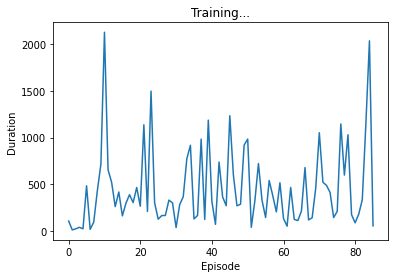

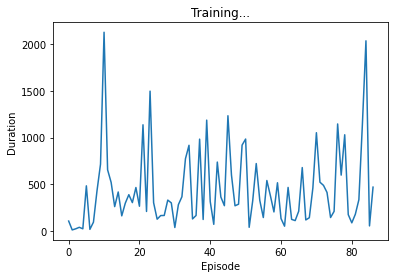

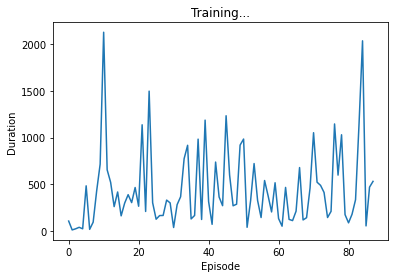

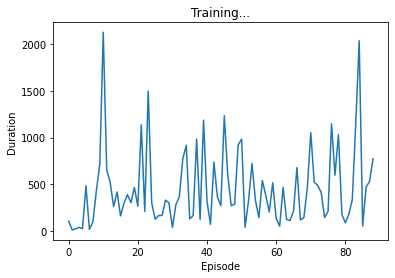

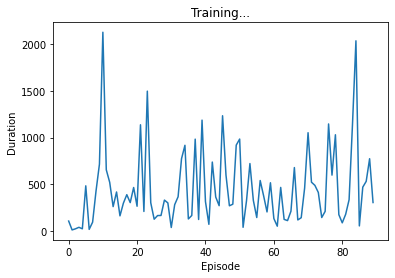

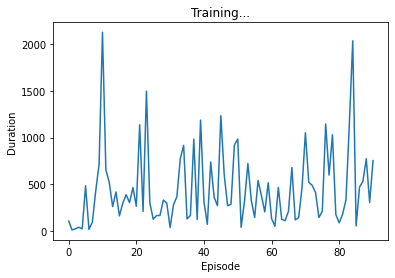

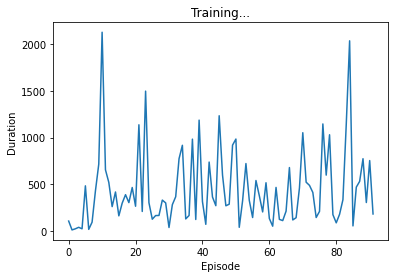

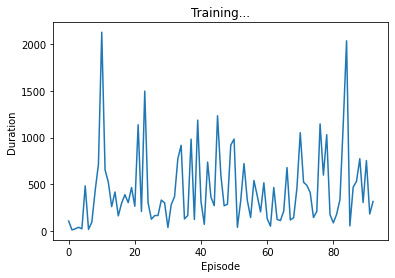

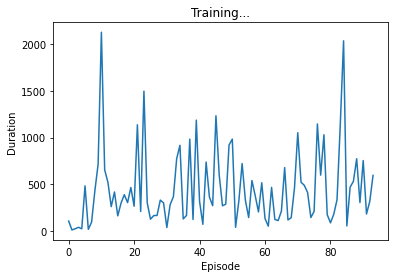

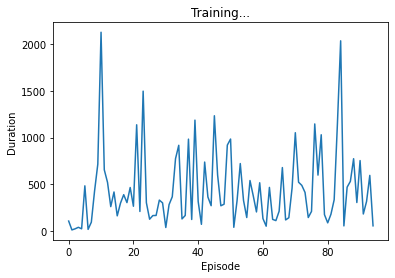

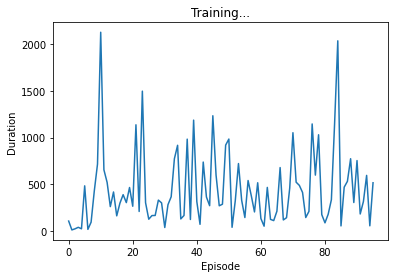

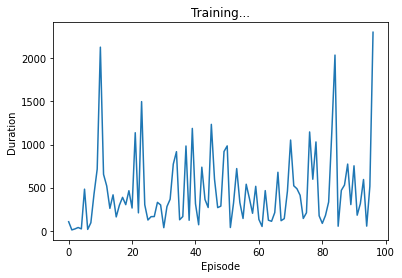

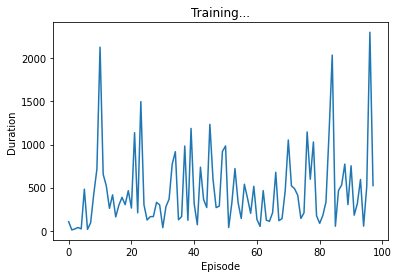

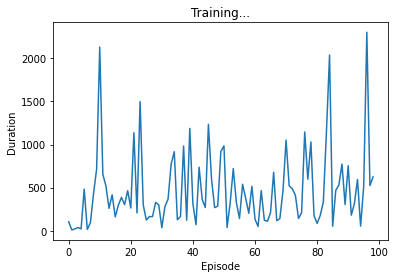

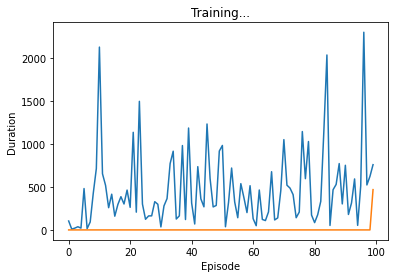

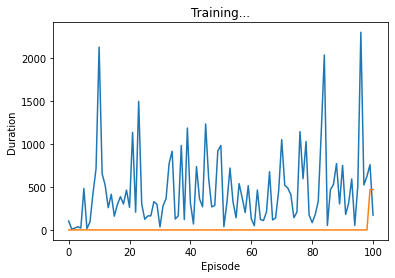

In [57]:
# Main training loop


from itertools import count

num_episodes = 100
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    state = None

    for t in count():
        # Select and perform an action for each cargo

        flag = False # indicates if we reached final step in this iteration

        for cargo_wanted in range(1, env.cargo_count + 1):

            state = env.get_state(cargo_wanted)
         
            # Select action
            action_idx = select_action(state.unsqueeze(0))


            # # perform the action
            reward, done = env.step(action_idx[0][0].item(), cargo_wanted)
            reward = torch.tensor([reward], device=device)
   

            # Get new state
            if not env.is_done():
                next_state = env.get_state(cargo_wanted)
                memory.push(state.unsqueeze(0), action_idx[0][0].item(), next_state.unsqueeze(0), reward)
            else:
                next_state = None
              
                memory.push(state.unsqueeze(0), action_idx[0][0].item(), None, reward)
                flag = True

            

            # Perform one step of the optimization (on the policy network)
            optimize_model()
            # if flag:
            #   break

            if env.is_done():
               
                episode_durations.append(t + 1)
                plot_durations()
                flag = True
                break

            # Update the target network, copying all weights and biases in DQN
            if t % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())
      
     # Break if we are done
        if flag:
          break



In [58]:
# saving a the models
torch.save(target_net.state_dict(), "target_model.pt")
torch.save(policy_net.state_dict(), "policy_model.pt")